<a href="https://colab.research.google.com/github/MTS0222/Users-Lifetime/blob/main/user_LifeTime_for_batch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Task Description

1. **Upload the data using the following link:**
   [https://drive.google.com/file/d/19xVK26UvRUV6ZXYY_1Dq-6zJKBrigbr6](https://drive.google.com/file/d/19xVK26UvRUV6ZXYY_1Dq-6zJKBrigbr6)

2. **Convert the revenue data into a single currency** (e.g., EUR) using the exchange rate at the time of the transaction.  
   *Recommendation: use `yfinance`.*

3. **Calculate user lifetime using one of the following methods:**
   - Use the transaction index of a user and treat it as their lifetime.
   - Use the number of full months from the user's first purchase as their lifetime.

4. **Calculate LTV (Lifetime Value)** using a convenient method.

5. **Plot a graph showing the relationship between ARPU (Average Revenue Per User) and LT (Lifetime).**

6. **Find the optimal curve that describes the relationship and its parameters.**  
   Add the curve to the graph.


In [2]:
!pip install yfinance

In [2]:
import yfinance as yf
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit

In [49]:
df = pd.read_csv('data.txt', delimiter = ';')

In [50]:
df.to_csv("data.csv", index=False)

In [51]:
df.head()

,date,user_id,transaction_id,price,currency
0,2020-11-08 02:07:08.526826,1,ec308451c1d095c528cfa3c009ea7235,10,EUR
1,2020-12-08 16:04:48.983707,1,ab35e84a215f0f711ed629c2abb9efa0,10,EUR
2,2021-01-08 09:08:27.726937,1,f0f421418433ba3cb592238eb7e51441,10,EUR
3,2021-02-08 19:02:26.349287,1,34b8a5e9772cd73daba26c68a209127f,10,EUR
4,2021-03-08 13:18:24.150412,1,2cb17e69baebaeed67190ad729bb2601,10,EUR


In [52]:
df.isna().sum()

,0
date,0
user_id,0
transaction_id,0
price,0
currency,0


In [ ]:
df['user_id'].unique()

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100])

In [ ]:
df['currency'].unique()

array(['EUR', 'AUD', 'USD', 'UAH'], dtype=object)

In [ ]:
len(df)

423

In [53]:
df['date'] = pd.to_datetime(df['date']).dt.floor('D')

**Convert the revenue data into a single currency (USD)**

In [54]:
print(df['date'].min(), df['date'].max())

2020-11-08 00:00:00 2021-06-08 00:00:00


In [55]:
# defining function for getting exchange rate
start = datetime(2020, 11, 3)
end = datetime(2021, 6, 8)

# get exchange rates
def get_rate(ticker):
    data = yf.Ticker(ticker).history(start=start, end=end, interval='1d')
    # using average of open and closing values
    # (my initial idea was to use values for exact timing but this data is only
    # available for short periods)
    data['avg_rate'] = data[['Open', 'Close']].mean(axis=1)
    data = data[['avg_rate']]
    data.index = data.index.tz_localize(None)
    return data.reset_index().rename(columns={'Date': 'date'})

data_aud = get_rate("AUDUSD=X")
data_eur = get_rate("EURUSD=X")
data_uah = get_rate("UAHUSD=X")

In [56]:
# Match each transaction with its corresponding exchange rate based on currency and date
# For each currency (AUD, EUR, UAH), filter the main DataFrame
# merge with historical exchange rate data on the 'date' column (left join to preserve all records),
# and fill any missing exchange rates using forward and backward fill to handle
# non-trading days

df_aud = df[df['currency'] == 'AUD'].merge(data_aud, on='date', how='left')
df_aud['avg_rate'] = df_aud['avg_rate'].ffill().bfill()

df_eur = df[df['currency'] == 'EUR'].merge(data_eur, on='date', how='left')
df_eur['avg_rate'] = df_eur['avg_rate'].ffill().bfill()

df_uah = df[df['currency'] == 'UAH'].merge(data_uah, on='date', how='left')
df_uah['avg_rate'] = df_uah['avg_rate'].ffill().bfill()

In [57]:
# i chose to convert all currencies to USD because USD was the only currency
# with consistent historical exchange rate data available for all currencies in our dataset.
df_usd = df[df['currency'] == 'USD'].copy()
df_usd['avg_rate'] = 1

In [58]:
# stacking them back together
df_final = pd.concat([df_aud, df_usd, df_uah, df_eur], ignore_index=True)
df_final['price_USD'] = df_final['price'] * df_final['avg_rate']
df_final.to_csv("df_final.csv", index=False)
df = df_final

In [6]:
#df = pd.read_csv("df_final.csv")
#df['date'] = pd.to_datetime(df['date'])

In [13]:
df['month'] = df['date'].dt.to_period('M').astype(str)

**Calculate user lifetime using the number of full months from the user's first purchase as their lifetime**

In [7]:
first_purchase = df.groupby('user_id')['date'].min()
last_purchase = df.groupby('user_id')['date'].max()

# calculate customer lifetime in months
lifetime_months = (
    (last_purchase.dt.year - first_purchase.dt.year) * 12 +
    (last_purchase.dt.month - first_purchase.dt.month)
)

# merge lifetime data back into the main DataFrame
df = df.merge(lifetime_months.rename('lifetime_months'), on='user_id', how='left')

In [8]:
# check if users might have incomplete months
# from what i saw in the dataset, users only pay for subscription (same day each month)
# but i decided to verify this
not_full_months = (last_purchase.dt.day < first_purchase.dt.day).astype(int)
not_full_months.mean()

np.float64(0.0)

In [9]:
df.head(3)

,date,user_id,transaction_id,price,currency,avg_rate,price_USD,lifetime_months
0,2020-11-08,2,f9c340648e746ce4f8ea6dde4e3538f9,15,AUD,0.741772,11.126585,2
1,2020-12-08,2,5229803558d4b78950dbe86955292f03,15,AUD,0.741772,11.126585,2
2,2021-01-08,2,c62d9e9c826d00c9a58597558f117ad8,15,AUD,0.776900,11.653500,2


**Calculate LTV (Lifetime Value)**

In [10]:
# calculate total revenue per user in USD (Lifetime Value)
# using .transform() to get sum for unique users in each row
df['LTV'] = df.groupby('user_id')['price_USD'].transform('sum')

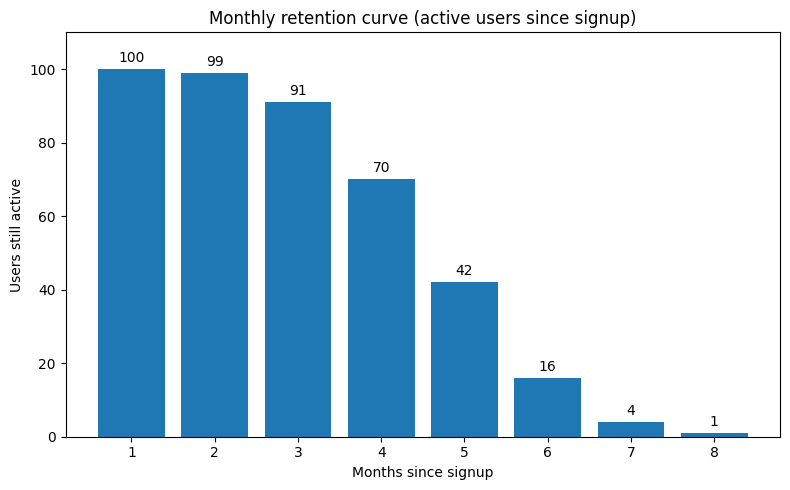

In [23]:
retention_rate = df.groupby('month')['user_id'].agg('nunique')

values = retention_rate.values
n_months = len(values)
month_idx = np.arange(1, n_months+1)

plt.figure(figsize=(8,5))
bars = plt.bar(month_idx, values)
plt.xticks(month_idx)

max_h = retention_rate.max()
plt.ylim(0, max_h * 1.1)

plt.xlabel('Months since signup')
plt.ylabel('Users still active')
plt.title('Monthly retention curve (active users since signup)')

for bar in bars:
    h = bar.get_height()
    plt.annotate(f'{int(h)}',
                 xy=(bar.get_x() + bar.get_width()/2, h),
                 xytext=(0,3), textcoords='offset points',
                 ha='center', va='bottom')

plt.tight_layout()
plt.show()

In [25]:
monthly_summary = (
    df
    .groupby('month')
    .agg(
        user_count    = ('user_id',  'nunique'),
        total_revenue = ('price_USD', 'sum')
    )
    .reset_index()
)
monthly_summary['ARPU'] = monthly_summary['total_revenue'] / monthly_summary['user_count']

monthly_summary


,month,user_count,total_revenue,ARPU
0,2020-11,100,1186.525145,11.865251
1,2020-12,99,1161.167413,11.728964
2,2021-01,91,1083.859034,11.910539
3,2021-02,70,832.174690,11.888210
4,2021-03,42,498.730129,11.874527
5,2021-04,16,188.437457,11.777341
6,2021-05,4,46.257344,11.564336
7,2021-06,1,11.419115,11.419115


In [26]:
cumulative_revenue = []
SUM = 0

for i in range(len(monthly_summary)):
    SUM += monthly_summary.iloc[i]['total_revenue']
    cumulative_revenue.append((i + 1, SUM))

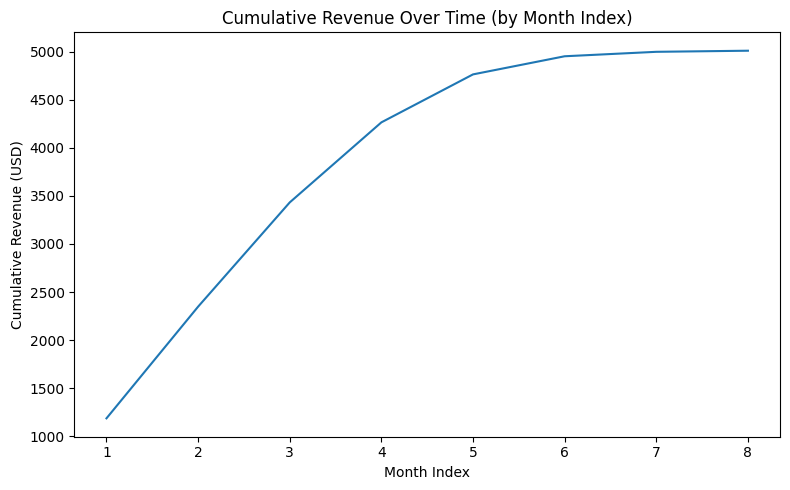

In [27]:
cumulative_df = pd.DataFrame(cumulative_revenue, columns=['month_index', 'cumulative_revenue'])

# Plot cumulative revenue over month index
plt.figure(figsize=(8, 5))
plt.plot(cumulative_df['month_index'], cumulative_df['cumulative_revenue'])
plt.title('Cumulative Revenue Over Time (by Month Index)')
plt.xlabel('Month Index')
plt.ylabel('Cumulative Revenue (USD)')
plt.tight_layout()
plt.show()

**Plot a graph showing the relationship between ARPU (Average Revenue Per User) and LT (Lifetime)**

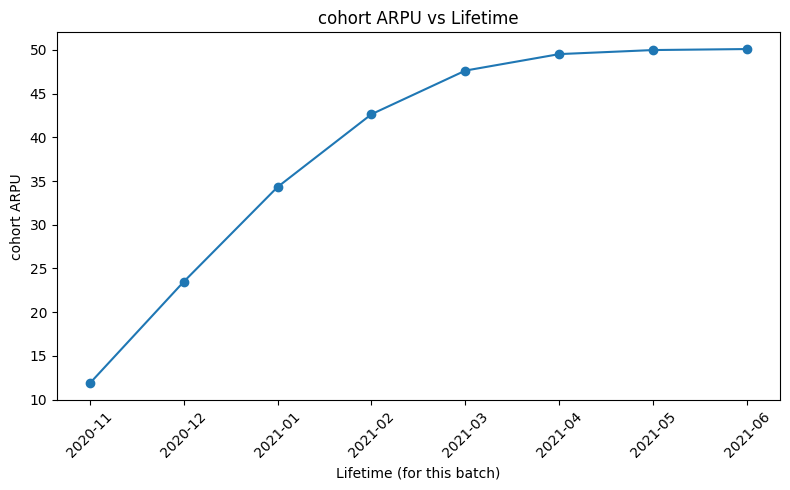

In [70]:
batch_size = monthly_summary.loc[0, 'user_count']
monthly_summary['rolling_revenue'] = monthly_summary['total_revenue'].cumsum()
monthly_summary['cohort_ARPU'] = monthly_summary['rolling_revenue'] / batch_size

monthly_summary['month_index'] = range(len(monthly_summary))

plt.figure(figsize=(8,5))
plt.plot(
    monthly_summary['month_index'],
    monthly_summary['cohort_ARPU'],
    marker='o',
    linestyle='-'
)
plt.title('cohort ARPU vs Lifetime')
plt.xlabel('Lifetime (for this batch)')
plt.ylabel('cohort ARPU')
plt.xticks(monthly_summary['month_index'], monthly_summary['month'], rotation=45)
plt.tight_layout()
plt.show()

**Find the optimal curve that describes the relationship and its parameters (saturating exponential curve)**

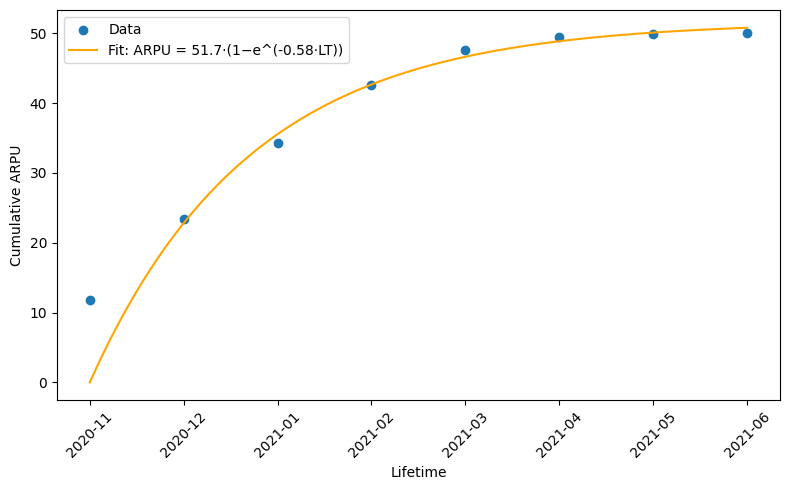

Saturation (A) = 51.69, Rate (B) = 0.58


In [68]:
# store data as lists
x = monthly_summary['month_index'].values
y = monthly_summary['cohort_ARPU'].values

# y = A * (1 - exp(-B*x)) saturating exponential
#A hight B time
def exp_model(x, A, B):
    return A * (1 - np.exp(-B * x))

popt, pcov = curve_fit(exp_model, x, y, p0=(y.max(), 0.4))
A, B = popt

x_fit = np.linspace(x.min(), x.max(), 200)
y_fit = exp_model(x_fit, A, B)

plt.figure(figsize=(8,5))
plt.scatter(x, y, label='Data')
plt.plot(x_fit, y_fit, color='orange', label=f'Fit: ARPU = {A:.1f}·(1−e^(-{B:.2f}·LT))')
plt.xlabel('Lifetime')
plt.ylabel('Cumulative ARPU')
plt.xticks(x, monthly_summary['month'], rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

print(f"Saturation (A) = {A:.2f}, Rate (B) = {B:.2f}")